In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Download dataset

In [3]:
!git clone https://github.com/anminhhung/dog-cat-dataset

Cloning into 'dog-cat-dataset'...
remote: Enumerating objects: 25004, done.
remote: Total 25004 (delta 0), reused 0 (delta 0), pack-reused 25004
Receiving objects: 100% (25004/25004), 541.49 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Updating files: 100% (25001/25001), done.


In [4]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)

    self.transform = transform

  def __len__(self):
    return len(self.list_images_path)

  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype('float')
    label = np.array(self.one_hot_label[self.list_labels[idx]]).astype('float')

    sample = (image, label)
    if self.transform:
      sample = self.transform(sample)

    return sample # image, label

In [5]:
class convertToTensor:
  def __call__(self, sample):
    image, label = sample

    # opencv image: H x W x C
    # torch tensor: C x H x W
    image = torch.from_numpy(image).permute(2, 0, 1).float()
    label = torch.from_numpy(label).long()

    return (image, label)

In [6]:
transformed_train_data = DogCatDataset('dog-cat-dataset/data/train', transform=transforms.Compose([convertToTensor()]))
transformed_test_data = DogCatDataset('dog-cat-dataset/data/test', transform=transforms.Compose([convertToTensor()]))

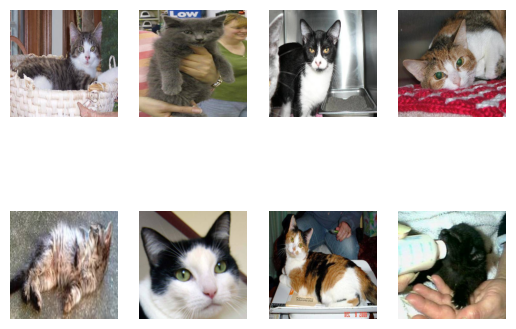

In [7]:
col = 4
row = 2

fig = plt.figure()
for index in range(1, col*row + 1):
  plt.subplot(row, col, index)
  plt.axis('off')
  plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread(transformed_train_data.list_images_path[index]), cv2.COLOR_BGR2RGB), (224, 224)))

In [8]:
train_data_loader = DataLoader(transformed_train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=32, shuffle=True)

# Base Conv for yolo

In [9]:
import torch
import torch.nn as nn


class SiLU(nn.Module):
    @staticmethod
    def forward(x):
        return x * torch.sigmoid(x)


def get_conv2d(c1, c2, k, p, s, d, g, bias=False):
    conv = nn.Conv2d(c1, c2, k, stride=s, padding=p, dilation=d, groups=g, bias=bias)

    return conv


def get_activation(act_type=None):
    if act_type == 'relu':
        return nn.ReLU(inplace=True)
    elif act_type == 'lrelu':
        return nn.LeakyReLU(0.1, inplace=True)
    elif act_type == 'mish':
        return nn.Mish(inplace=True)
    elif act_type == 'silu':
        return nn.SiLU(inplace=True)


def get_norm(norm_type, dim):
    if norm_type == 'BN':
        return nn.BatchNorm2d(dim)
    elif norm_type == 'GN':
        return nn.GroupNorm(num_groups=32, num_channels=dim)


# Basic conv layer
class Conv(nn.Module):
    def __init__(self,
                 c1,                   # in channels
                 c2,                   # out channels
                 k=1,                  # kernel size
                 p=0,                  # padding
                 s=1,                  # padding
                 d=1,                  # dilation
                 act_type='lrelu',     # activation
                 norm_type='BN',       # normalization
                 depthwise=False):
        super(Conv, self).__init__()
        convs = []
        add_bias = False if norm_type else True
        if depthwise:
            convs.append(get_conv2d(c1, c1, k=k, p=p, s=s, d=d, g=c1, bias=add_bias))
            # depthwise conv
            if norm_type:
                convs.append(get_norm(norm_type, c1))
            if act_type:
                convs.append(get_activation(act_type))
            # pointwise conv
            convs.append(get_conv2d(c1, c2, k=1, p=0, s=1, d=d, g=1, bias=add_bias))
            if norm_type:
                convs.append(get_norm(norm_type, c2))
            if act_type:
                convs.append(get_activation(act_type))

        else:
            convs.append(get_conv2d(c1, c2, k=k, p=p, s=s, d=d, g=1, bias=add_bias))
            if norm_type:
                convs.append(get_norm(norm_type, c2))
            if act_type:
                convs.append(get_activation(act_type))

        self.convs = nn.Sequential(*convs)


    def forward(self, x):
        return self.convs(x)

In [10]:
# BottleNeck
class Bottleneck(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 expand_ratio=0.5,
                 shortcut=False,
                 depthwise=False,
                 act_type='silu',
                 norm_type='BN'):
        super(Bottleneck, self).__init__()
        inter_dim = int(out_dim * expand_ratio)  # hidden channels
        self.cv1 = Conv(in_dim, inter_dim, k=1, norm_type=norm_type, act_type=act_type)
        self.cv2 = Conv(inter_dim, out_dim, k=3, p=1, norm_type=norm_type, act_type=act_type, depthwise=depthwise)
        self.shortcut = shortcut and in_dim == out_dim

    def forward(self, x):
        h = self.cv2(self.cv1(x))

        return x + h if self.shortcut else h


# ResBlock
class ResBlock(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 nblocks=1,
                 act_type='silu',
                 norm_type='BN'):
        super(ResBlock, self).__init__()
        assert in_dim == out_dim
        self.m = nn.Sequential(*[
            Bottleneck(in_dim, out_dim, expand_ratio=0.5, shortcut=True,
                       norm_type=norm_type, act_type=act_type)
                       for _ in range(nblocks)
                       ])

    def forward(self, x):
        return self.m(x)

# Yolov5 Backbone

![image](https://www.researchgate.net/publication/349299852/figure/fig2/AS:991096909877249@1613307325220/The-network-architecture-of-EfficientDet-It-consists-of-three-parts-1-Backbone.jpg)

In [14]:
# Spatial Pyramid Pooling
class SPPF(nn.Module):
    def __init__(self, in_dim, out_dim, expand_ratio=0.5, pooling_size=5, act_type='silu', norm_type='BN'):
        super().__init__()
        inter_dim = int(in_dim * expand_ratio)
        self.out_dim = out_dim
        self.cv1 = Conv(in_dim, inter_dim, k=1, act_type=act_type, norm_type=norm_type)
        self.cv2 = Conv(inter_dim * 4, out_dim, k=1, act_type=act_type, norm_type=norm_type)
        self.m = nn.MaxPool2d(kernel_size=pooling_size, stride=1, padding=pooling_size // 2)

    def forward(self, x):
        x = self.cv1(x)
        y1 = self.m(x)
        y2 = self.m(y1)

        return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))

class CSPBlock(nn.Module):
    def __init__(self,
                 in_dim,
                 out_dim,
                 expand_ratio=0.5,
                 nblocks=1,
                 shortcut=False,
                 depthwise=False,
                 act_type='silu',
                 norm_type='BN'):
        super(CSPBlock, self).__init__()
        inter_dim = int(out_dim * expand_ratio)
        self.cv1 = Conv(in_dim, inter_dim, k=1, norm_type=norm_type, act_type=act_type)
        self.cv2 = Conv(in_dim, inter_dim, k=1, norm_type=norm_type, act_type=act_type)
        self.cv3 = Conv(2 * inter_dim, out_dim, k=1, norm_type=norm_type, act_type=act_type)
        self.m = nn.Sequential(*[
            Bottleneck(inter_dim, inter_dim, expand_ratio=1.0, shortcut=shortcut,
                       norm_type=norm_type, act_type=act_type, depthwise=depthwise)
                       for _ in range(nblocks)
                       ])

    def forward(self, x):
        x1 = self.cv1(x)
        x2 = self.cv2(x)
        x3 = self.m(x1)
        out = self.cv3(torch.cat([x3, x2], dim=1))

        return out

# CSPDarkNet
class CSPDarkNet(nn.Module):
    def __init__(self, depth=1.0, width=1.0, act_type='silu', norm_type='BN', depthwise=False):
        super(CSPDarkNet, self).__init__()
        self.feat_dims = [64, 128, 256, 512, 1024]
        # P1/2
        self.layer_1 = Conv(3, self.feat_dims[0], k=6, p=2, s=2, act_type=act_type, norm_type=norm_type, depthwise=depthwise)
        # P2/4
        self.layer_2 = nn.Sequential(
            Conv(self.feat_dims[0], self.feat_dims[1], k=3, p=1, s=2, act_type=act_type, norm_type=norm_type, depthwise=depthwise),
            CSPBlock(
                     in_dim       = self.feat_dims[1],
                     out_dim      = self.feat_dims[1],
                     expand_ratio = 0.5,
                     nblocks      = round(3*depth),
                     shortcut     = True,
                     act_type     = act_type,
                     norm_type    = norm_type,
                     depthwise    = depthwise)
        )
        # P3/8
        self.layer_3 = nn.Sequential(
            Conv(self.feat_dims[1], self.feat_dims[2], k=3, p=1, s=2, act_type=act_type, norm_type=norm_type, depthwise=depthwise),
            CSPBlock(
                     in_dim       = self.feat_dims[2],
                     out_dim      = self.feat_dims[2],
                     expand_ratio = 0.5,
                     nblocks      = round(9*depth),
                     shortcut     = True,
                     act_type     = act_type,
                     norm_type    = norm_type,
                     depthwise    = depthwise)
        )
        # P4/16
        self.layer_4 = nn.Sequential(
            Conv(self.feat_dims[2], self.feat_dims[3], k=3, p=1, s=2, act_type=act_type, norm_type=norm_type, depthwise=depthwise),
            CSPBlock(
                     in_dim       = self.feat_dims[3],
                     out_dim      = self.feat_dims[3],
                     expand_ratio = 0.5,
                     nblocks      = round(9*depth),
                     shortcut     = True,
                     act_type     = act_type,
                     norm_type    = norm_type,
                     depthwise    = depthwise)
        )
        # P5/32
        self.layer_5 = nn.Sequential(
            Conv(self.feat_dims[3], self.feat_dims[4], k=3, p=1, s=2, act_type=act_type, norm_type=norm_type, depthwise=depthwise),
            SPPF(self.feat_dims[4], self.feat_dims[4], expand_ratio=0.5), # Raw Bi-FPN
            CSPBlock(
                     in_dim       = self.feat_dims[4],
                     out_dim      = self.feat_dims[4],
                     expand_ratio = 0.5,
                     nblocks      = round(3*depth),
                     shortcut     = True,
                     act_type     = act_type,
                     norm_type    = norm_type,
                     depthwise    = depthwise)
        )

    def forward(self, x):
        c1 = self.layer_1(x)
        c2 = self.layer_2(c1)
        c3 = self.layer_3(c2)
        c4 = self.layer_4(c3)
        c5 = self.layer_5(c4)

        return c5

class YoloV5_backbone(nn.Module):
    def __init__(self, n_classes=2):
        super(YoloV5_backbone, self).__init__()
        self.backbone = CSPDarkNet()

        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(in_features=50176, out_features=n_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.classifier(x)

        return x

In [15]:
model = YoloV5_backbone(2).to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

# Utils Train

In [17]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, ax = plt.subplots(figsize=(8, 4.5))

    ax.plot(train_acc, color="blue", label="Train_acc")
    ax.plot(valid_acc, color="red", label="Validation_acc")
    ax.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax.legend()
    fig.show()

  # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

    plot_losses(list_train_acc, list_val_acc)

    return model, optimizer, (train_losses, valid_losses)

# Train

Epochs: 0, Train_loss: 0.7871129532337189, Valid_loss: 0.6482250337388106, Train_accuracy: 61.675000000000004, Valid_accuracy: 61.86000000000001


<ipython-input-17-dd3484d2c16a>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


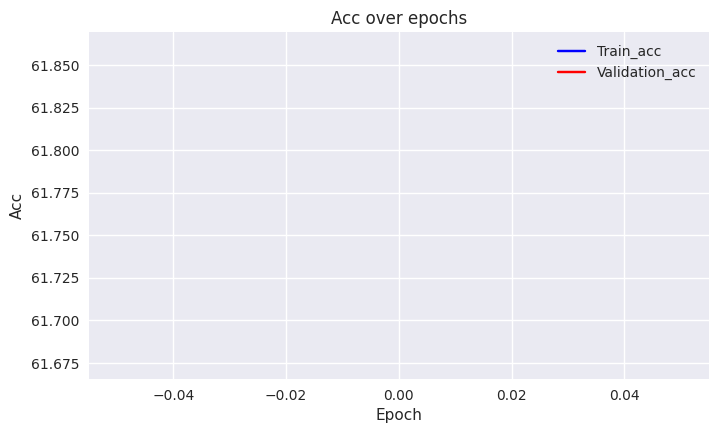

In [18]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 1, device)